# Importing Python librabies

In [1]:
%matplotlib inlineimport warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

UsageError: unrecognized arguments: warnings


# 1. Reading Data

In [2]:
import pandas as pd
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 2. Data Preprocessing

In [5]:
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [6]:
#preprocessing of `project_subject_categories`


catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


In [8]:
#word_count_in_project_title
word_count= []
for w in project_data["project_title"]:
    word_len= len(w.split())
    word_count.append(word_len)

In [9]:
project_data["project_title_word_count"]= word_count

In [10]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)


In [11]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,project_title_word_count,essay
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,6,I have been fortunate enough to use the Fairy ...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,4,Imagine being 8-9 years old. You're in your th...


In [12]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [13]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [14]:
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,project_title_word_count,essay,price,quantity
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,6,I have been fortunate enough to use the Fairy ...,725.05,4
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,4,Imagine being 8-9 years old. You're in your th...,213.03,8


In [15]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
sent = decontracted(project_data['essay'].values[50000])
print(sent)
print("="*50)

My students are in the 4th grade at Pettit Park, which is a 1:1 technology school in Indiana. Our school is title 1 with the highest poverty rate in the district. This is why it is so important to me that my student receive every opportunity they can. We are a room of authors, mathematicians, scientists, poets, teachers and learners! Your donations are what helps me bring authentic, rigorous, engaging learning into the classroom. We appreciate you and all your support.This will be our second year participating in the 100 mile club. Last year my students had so much fun tracking their miles and earning their prizes. At our school each student is challenged to run or walk 100 miles throughout the school year. They receive prizes at 25, 50, 75 and 100 miles. They love it and it really gets them thinking about their fitness.\r\n\r\nLast year it was very hard to keep track of their miles. Students ended up walking/running more miles than they could record because we had no way of knowing ho

In [17]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)


My students are in the 4th grade at Pettit Park, which is a 1:1 technology school in Indiana. Our school is title 1 with the highest poverty rate in the district. This is why it is so important to me that my student receive every opportunity they can. We are a room of authors, mathematicians, scientists, poets, teachers and learners! Your donations are what helps me bring authentic, rigorous, engaging learning into the classroom. We appreciate you and all your support.This will be our second year participating in the 100 mile club. Last year my students had so much fun tracking their miles and earning their prizes. At our school each student is challenged to run or walk 100 miles throughout the school year. They receive prizes at 25, 50, 75 and 100 miles. They love it and it really gets them thinking about their fitness.    Last year it was very hard to keep track of their miles. Students ended up walking/running more miles than they could record because we had no way of knowing how ma

In [18]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My students are in the 4th grade at Pettit Park which is a 1 1 technology school in Indiana Our school is title 1 with the highest poverty rate in the district This is why it is so important to me that my student receive every opportunity they can We are a room of authors mathematicians scientists poets teachers and learners Your donations are what helps me bring authentic rigorous engaging learning into the classroom We appreciate you and all your support This will be our second year participating in the 100 mile club Last year my students had so much fun tracking their miles and earning their prizes At our school each student is challenged to run or walk 100 miles throughout the school year They receive prizes at 25 50 75 and 100 miles They love it and it really gets them thinking about their fitness Last year it was very hard to keep track of their miles Students ended up walking running more miles than they could record because we had no way of knowing how many miles they accumulat

In [19]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [20]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:12<00:00, 1510.02it/s]


In [21]:
# after preprocesing
preprocessed_essays[20000]

'person person no matter small dr seuss teach smallest students biggest enthusiasm learning students learn many different ways using senses multiple intelligences use wide range techniques help students succeed students class come variety different backgrounds makes wonderful sharing experiences cultures including native americans school caring community successful learners seen collaborative student project based learning classroom kindergarteners class love work hands materials many different opportunities practice skill mastered social skills work cooperatively friends crucial aspect kindergarten curriculum montana perfect place learn agriculture nutrition students love role play pretend kitchen early childhood classroom several kids ask try cooking real food take idea create common core cooking lessons learn important math writing concepts cooking delicious healthy food snack time students grounded appreciation work went making food knowledge ingredients came well healthy bodies pr

In [22]:
project_data["preprocessed_essays"]=preprocessed_essays

In [23]:

# similarly you can preprocess the titles also
from tqdm import tqdm
Prepro_Project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    Prepro_Project_title.append(sent.lower().strip())
    
Prepro_Project_title[2000]

100%|██████████| 109248/109248 [00:03<00:00, 31410.25it/s]


'empowering students art makerspace'

In [24]:
project_data["prepro_project_title"]=Prepro_Project_title

In [25]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'project_title_word_count',
       'essay', 'price', 'quantity', 'preprocessed_essays',
       'prepro_project_title'],
      dtype='object')

In [26]:
project_data["teacher_prefix"]

0         Mrs.
1          Ms.
2         Mrs.
3         Mrs.
4         Mrs.
5         Mrs.
6         Mrs.
7          Ms.
8          Ms.
9         Mrs.
10         Ms.
11         Mr.
12        Mrs.
13        Mrs.
14        Mrs.
15        Mrs.
16        Mrs.
17        Mrs.
18        Mrs.
19        Mrs.
20        Mrs.
21        Mrs.
22         Mr.
23        Mrs.
24         Ms.
25         Ms.
26        Mrs.
27         Mr.
28        Mrs.
29         Ms.
          ... 
109218    Mrs.
109219     Ms.
109220    Mrs.
109221    Mrs.
109222     Ms.
109223     Ms.
109224     Mr.
109225     Mr.
109226    Mrs.
109227     Ms.
109228     Ms.
109229     Ms.
109230     Ms.
109231     Mr.
109232    Mrs.
109233    Mrs.
109234    Mrs.
109235     Ms.
109236     Mr.
109237    Mrs.
109238    Mrs.
109239     Ms.
109240     Ms.
109241     Ms.
109242    Mrs.
109243    Mrs.
109244     Ms.
109245    Mrs.
109246    Mrs.
109247    Mrs.
Name: teacher_prefix, Length: 109248, dtype: object

In [27]:
project_data["teacher_prefix"].fillna("None", inplace = True)

In [28]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,...,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,project_title_word_count,essay,price,quantity,preprocessed_essays,prepro_project_title
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,...,53,1,Math_Science,AppliedSciences Health_LifeScience,6,I have been fortunate enough to use the Fairy ...,725.05,4,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",...,4,1,SpecialNeeds,SpecialNeeds,4,Imagine being 8-9 years old. You're in your th...,213.03,8,imagine 8 9 years old third grade classroom se...,sensory tools focus


In [29]:
y= project_data["project_is_approved"]


In [30]:
train= project_data
train.drop(['project_is_approved'], axis=1, inplace=True)
train.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,project_title_word_count,essay,price,quantity,preprocessed_essays,prepro_project_title
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,...,My students need STEM kits to learn critical s...,53,Math_Science,AppliedSciences Health_LifeScience,6,I have been fortunate enough to use the Fairy ...,725.05,4,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",...,My students need Boogie Boards for quiet senso...,4,SpecialNeeds,SpecialNeeds,4,Imagine being 8-9 years old. You're in your th...,213.03,8,imagine 8 9 years old third grade classroom se...,sensory tools focus
2,74477,p189804,4a97f3a390bfe21b99cf5e2b81981c73,Mrs.,CA,2016-04-27 00:46:53,Grades PreK-2,Mobile Learning with a Mobile Listening Center,Having a class of 24 students comes with diver...,I have a class of twenty-four kindergarten stu...,...,My students need a mobile listening center to ...,10,Literacy_Language,Literacy,7,Having a class of 24 students comes with diver...,329.00,1,class 24 students comes diverse learners stude...,mobile learning mobile listening center
3,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,...,My students need flexible seating in the class...,2,AppliedLearning,EarlyDevelopment,5,I recently read an article about giving studen...,481.04,9,recently read article giving students choice l...,flexible seating flexible learning
4,33679,p137682,06f6e62e17de34fcf81020c77549e1d5,Mrs.,WA,2016-04-27 01:05:25,Grades 3-5,Going Deep: The Art of Inner Thinking!,"My students crave challenge, they eat obstacle...","We are an urban, public k-5 elementary school....",...,My students need copies of the New York Times ...,2,Literacy_Language,Literacy,7,"My students crave challenge, they eat obstacle...",17.74,14,students crave challenge eat obstacles breakfa...,going deep the art inner thinking


In [31]:
X=train.sample(20000)
y=y.sample(20000)

In [32]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify= y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# Preparing data for models

# Bag of Words

In [33]:

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_cv.shape, y_cv.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)

print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

(8978, 22) (8978,)
(6600, 22) (6600,)
(4422, 22) (4422,)
After vectorizations
(8978, 5000) (8978,)
(4422, 5000) (4422,)
(6600, 5000) (6600,)


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['prepro_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['prepro_project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['prepro_project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['prepro_project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(8978, 844) (8978,)
(4422, 844) (4422,)
(6600, 844) (6600,)


# TF_IDF

In [35]:
#using TFIDF vector modelling KNN
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values) 


(8978, 22) (8978,)
(4422, 22) (4422,)
(6600, 22) (6600,)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=10,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [36]:
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)
print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(8978, 5000) (8978,)
(4422, 5000) (4422,)
(6600, 5000) (6600,)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['prepro_project_title'].values) 


X_train_project_title_tfidf = vectorizer.transform(X_train['prepro_project_title'].values)
X_cv_project_title_tfidf = vectorizer.transform(X_cv['prepro_project_title'].values)
X_test_project_title_tfidf = vectorizer.transform(X_test['prepro_project_title'].values)
print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_train.shape)
print(X_cv_project_title_tfidf.shape, y_cv.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(8978, 844) (8978,)
(4422, 844) (4422,)
(6600, 844) (6600,)


# Word2Vec

In [38]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [39]:
# average Word2Vec
# compute average word2vec for each review.
import numpy as np
X_train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors.append(vector)

print(len(X_train_avg_w2v_vectors))
print(len(X_train_avg_w2v_vectors[0]))

100%|██████████| 8978/8978 [00:02<00:00, 3738.95it/s]

8978
300


In [40]:
# average Word2Vec
# compute average word2vec for each review.
import numpy as np
X_cv_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_avg_w2v_vectors.append(vector)

print(len(X_cv_avg_w2v_vectors))
print(len(X_cv_avg_w2v_vectors[0]))

100%|██████████| 4422/4422 [00:01<00:00, 3760.37it/s]

4422
300


In [41]:
# average Word2Vec
# compute average word2vec for each review.
X_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors.append(vector)

print(len(X_test_avg_w2v_vectors))
print(len(X_test_avg_w2v_vectors[0]))

100%|██████████| 6600/6600 [00:01<00:00, 3743.39it/s]

6600
300


In [42]:
X_train_avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as wor' vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors_title.append(vector)

print(len(X_train_avg_w2v_vectors_title))
print(len(X_train_avg_w2v_vectors_title[0]))

100%|██████████| 8978/8978 [00:00<00:00, 61599.41it/s]

8978
300


In [43]:
X_cv_avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_avg_w2v_vectors_title.append(vector)

print(len(X_cv_avg_w2v_vectors_title))
print(len(X_cv_avg_w2v_vectors_title[0]))

100%|██████████| 4422/4422 [00:00<00:00, 40668.54it/s]

4422
300


In [44]:
X_test_avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors_title.append(vector)

print(len(X_test_avg_w2v_vectors_title))
print(len(X_test_avg_w2v_vectors_title[0]))

100%|██████████| 6600/6600 [00:00<00:00, 58623.70it/s]

6600
300


# TFIDF Weighted W2V

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [46]:
# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_vectors_essay.append(vector)

print(len(train_tfidf_w2v_vectors_essay))
print(len(train_tfidf_w2v_vectors_essay[0]))

100%|██████████| 8978/8978 [00:13<00:00, 651.93it/s]

8978
300


In [47]:
# average Word2Vec
# compute average word2vec for each review.
cv_tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_vectors_essay.append(vector)

print(len(cv_tfidf_w2v_vectors_essay))
print(len(cv_tfidf_w2v_vectors_essay[0]))

100%|██████████| 4422/4422 [00:06<00:00, 655.15it/s]

4422
300


In [48]:
# average Word2Vec
# compute average word2vec for each review.
test_tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors_essay.append(vector)

print(len(test_tfidf_w2v_vectors_essay))
print(len(test_tfidf_w2v_vectors_essay[0]))

100%|██████████| 6600/6600 [00:09<00:00, 668.26it/s]

6600
300


In [49]:
# Similarly you can vectorize for title also
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['prepro_project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


In [50]:
train_tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_vectors_title.append(vector)

print(len(train_tfidf_w2v_vectors_title))
print(len(train_tfidf_w2v_vectors_title[0]))

100%|██████████| 8978/8978 [00:00<00:00, 30013.11it/s]

8978
300


In [51]:
cv_tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_vectors_title.append(vector)

print(len(cv_tfidf_w2v_vectors_title))
print(len(cv_tfidf_w2v_vectors_title[0]))

100%|██████████| 4422/4422 [00:00<00:00, 28761.61it/s]

4422
300


In [52]:
test_tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['prepro_project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors_title.append(vector)

print(len(test_tfidf_w2v_vectors_title))
print(len(test_tfidf_w2v_vectors_title[0]))

100%|██████████| 6600/6600 [00:00<00:00, 28656.41it/s]

6600
300


# One_hot_encoding_for_categorical_features

In [53]:
my_counter = Counter()
for school_state in project_data['school_state'].values:
    my_counter.update(school_state.split())

school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [54]:
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)

X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)


print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(8978, 51) (8978,)
(4422, 51) (4422,)
(6600, 51) (6600,)
['NH', 'VT', 'KY', 'SD', 'NE', 'WI', 'DE', 'MS', 'WA', 'IA', 'DC', 'ND', 'MT', 'NM', 'OH', 'ME', 'OR', 'KS', 'AR', 'TN', 'GA', 'NC', 'AZ', 'CO', 'NJ', 'MA', 'MN', 'MO', 'WV', 'PA', 'RI', 'OK', 'UT', 'FL', 'IL', 'AK', 'CT', 'VA', 'SC', 'TX', 'LA', 'ID', 'AL', 'HI', 'NV', 'MD', 'NY', 'IN', 'MI', 'WY', 'CA']


# Clean Categories

In [55]:
my_counter = Counter()
for clean_categories in project_data['clean_categories'].values:
    my_counter.update(clean_categories.split())

clean_categories_cat_dict = dict(my_counter)
sorted_clean_categories_cat_dict = dict(sorted(clean_categories_cat_dict.items(), key=lambda kv: kv[1]))

In [56]:
vectorizer = CountVectorizer(vocabulary=list(sorted_clean_categories_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_ohe = vectorizer.transform(X_cv['clean_categories'].values)

X_test_clean_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_ohe.shape, y_train.shape)
print(X_cv_clean_ohe.shape, y_cv.shape)


print(X_test_clean_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(8978, 9) (8978,)
(4422, 9) (4422,)
(6600, 9) (6600,)
['Literacy_Language', 'SpecialNeeds', 'Health_Sports', 'History_Civics', 'AppliedLearning', 'Math_Science', 'Music_Arts', 'Warmth', 'Care_Hunger']


# Clean_Subcategories

In [57]:
my_counter = Counter()
for clean_subcategories in project_data['clean_subcategories'].values:
    my_counter.update(clean_subcategories.split())

clean_subcategories_cat_dict = dict(my_counter)
sorted_clean_subcategories_cat_dict = dict(sorted(clean_subcategories_cat_dict.items(), key=lambda kv: kv[1]))

In [58]:
vectorizer = CountVectorizer(vocabulary=list(sorted_clean_subcategories_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_sub_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_sub_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)

X_test_clean_sub_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_sub_ohe.shape, y_train.shape)
print(X_cv_clean_sub_ohe.shape, y_cv.shape)


print(X_test_clean_sub_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(8978, 30) (8978,)
(4422, 30) (4422,)
(6600, 30) (6600,)
['CharacterEducation', 'VisualArts', 'Economics', 'ForeignLanguages', 'Other', 'Extracurricular', 'NutritionEducation', 'Literacy', 'Health_Wellness', 'Literature_Writing', 'EnvironmentalScience', 'History_Geography', 'Mathematics', 'PerformingArts', 'CommunityService', 'TeamSports', 'EarlyDevelopment', 'ParentInvolvement', 'SocialSciences', 'FinancialLiteracy', 'Gym_Fitness', 'Civics_Government', 'AppliedSciences', 'SpecialNeeds', 'College_CareerPrep', 'ESL', 'Health_LifeScience', 'Music', 'Warmth', 'Care_Hunger']


# Teacher_prefix

In [59]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    my_counter.update(teacher_prefix.split())

teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [60]:
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values.astype('U'))

X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values.astype('U'))

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)

print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(8978, 6) (8978,)
(4422, 6) (4422,)
(6600, 6) (6600,)
['None', 'Dr.', 'Teacher', 'Mrs.', 'Mr.', 'Ms.']


# Projct_grade_category

In [61]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [62]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [63]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)

X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)

print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(8978, 5) (8978,)
(4422, 5) (4422,)
(6600, 5) (6600,)
['PreK-2', '6-8', 'Grades', '3-5', '9-12']


# Numerical_data

In [64]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_train.shape)

print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(8978, 1) (8978,)
(4422, 1) (8978,)
(6600, 1) (6600,)


In [65]:

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_prev_projects_norm.shape, y_train.shape)
print(X_cv_prev_projects_norm.shape, y_cv.shape)
print(X_test_prev_projects_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(8978, 1) (8978,)
(4422, 1) (4422,)
(6600, 1) (6600,)


In [66]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['project_title_word_count'].values.reshape(-1,1))

X_train_title_count_norm = normalizer.transform(X_train['project_title_word_count'].values.reshape(-1,1))
X_cv_title_count_norm = normalizer.transform(X_cv['project_title_word_count'].values.reshape(-1,1))
X_test_title_count_norm = normalizer.transform(X_test['project_title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_title_count_norm.shape, y_train.shape)
print(X_cv_title_count_norm.shape, y_cv.shape)
print(X_test_title_count_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(8978, 1) (8978,)
(4422, 1) (4422,)
(6600, 1) (6600,)


In [67]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_title_bow, X_train_state_ohe,X_train_clean_ohe,X_train_clean_sub_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_prev_projects_norm,X_train_title_count_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_title_bow, X_cv_state_ohe,X_cv_clean_ohe,X_cv_clean_sub_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_prev_projects_norm,X_cv_title_count_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_title_bow, X_test_state_ohe, X_test_clean_ohe,X_test_clean_sub_ohe,X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_prev_projects_norm,X_test_title_count_norm)).tocsr()

In [68]:
from imblearn.over_sampling import SMOTE
X_re, y_re = SMOTE().fit_resample(X_tr, y_train)
print(sorted(Counter(y_re).items()))

[(0, 7629), (1, 7629)]


In [69]:
print(X_re.shape)
print(X_cv.shape)
print(X_test.shape)

print(y_re.shape)
print(y_cv.shape)
print(y_test.shape)

(15258, 5948)
(4422, 22)
(6600, 22)
(15258,)
(4422,)
(6600,)


In [70]:
#Method 1: Simple for loop (if you are having memory limitations use this)

def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points 
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [71]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 11, 21, 31, 41, 51, 61, 71,81,91,101]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_re, y_re)

    y_train_pred = batch_predict(neigh, X_re)    
    y_cv_pred = batch_predict(neigh, X_cr)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_re,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

100%|██████████| 11/11 [05:01<00:00, 27.64s/it]


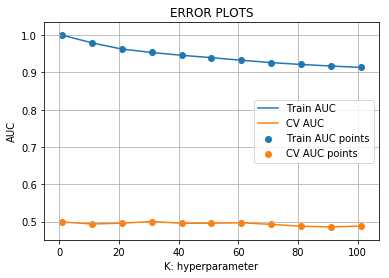

In [72]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


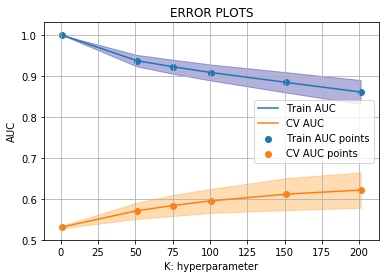

In [73]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[1,51,75,101,151,201]}

clf = GridSearchCV(neigh, parameters, cv= 3, scoring='roc_auc')

clf.fit(X_re, y_re)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


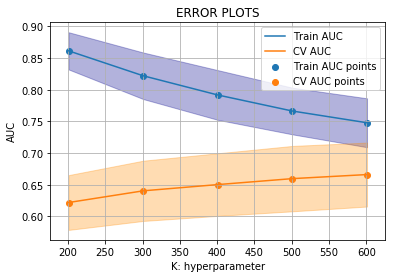

In [74]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[201,301,401,501,601]}

clf = GridSearchCV(neigh, parameters, cv= 3, scoring='roc_auc')

clf.fit(X_re, y_re)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


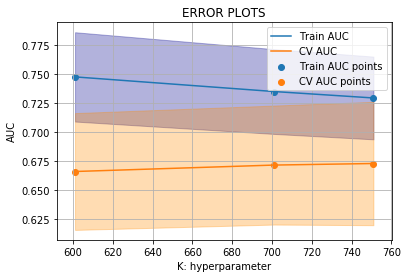

In [75]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[601,701,751]}

clf = GridSearchCV(neigh, parameters, cv= 3, scoring='roc_auc')

clf.fit(X_re, y_re)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


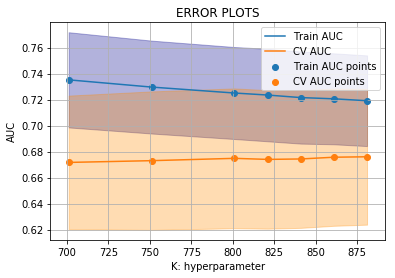

In [76]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()

parameters = {'n_neighbors':[701,751,801,821,841,861,881]}

clf = GridSearchCV(neigh, parameters, cv= 3, scoring='roc_auc')

clf.fit(X_re, y_re)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



In [77]:
# Optimal value of depth
print("Best HyperParameter: ",clf.best_params_)
print("Best Score: %.2f%%"%(clf.best_score_))

Best HyperParameter:  {'n_neighbors': 881}
Best Score: 0.68%


In [78]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
#keeping k =201 as best param because after that it's slower to converge
best_k = 601

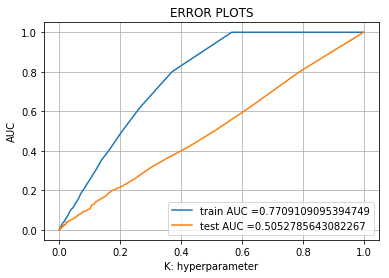

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_re, y_re)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_re)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_re, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [80]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [81]:
print("="*100)
from sklearn.metrics import confusion_matrix
import numpy as np
print("Train confusion matrix")
print(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2455398121850207 for threshold 0.002
[[3305 4324]
 [   0 7629]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2498653369732232 for threshold 0.033
[[ 889  102]
 [4977  632]]


the maximum value of tpr*(1-fpr) 0.2455398121850207 for threshold 0.002


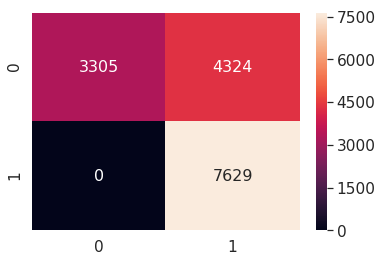

In [82]:
import seaborn as sns
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

# KNN using TF_IDF

In [83]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf,X_train_project_title_tfidf, X_train_state_ohe,X_train_clean_ohe,X_train_clean_sub_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_prev_projects_norm,X_train_title_count_norm)).tocsr()
X_cr1 = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf, X_cv_state_ohe,X_cv_clean_ohe,X_cv_clean_sub_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_prev_projects_norm,X_cv_title_count_norm)).tocsr()
X_te1 = hstack((X_test_essay_tfidf,X_test_project_title_tfidf, X_test_state_ohe, X_test_clean_ohe,X_test_clean_sub_ohe,X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_prev_projects_norm,X_test_title_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr1.shape, y_train.shape)
print(X_cr1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)
print("="*100)

Final Data matrix
(8978, 5948) (8978,)
(4422, 5948) (4422,)
(6600, 5948) (6600,)


In [84]:
from imblearn.over_sampling import SMOTE
X_re1, y_re1 = SMOTE().fit_resample(X_tr1, y_train)
print(sorted(Counter(y_re).items()))

[(0, 7629), (1, 7629)]


In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 11, 21, 31, 41, 51, 61, 71,81,91,101]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_re1, y_re1)

    y_train_pred = batch_predict(neigh, X_re1)    
    y_cv_pred = batch_predict(neigh, X_cr1)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_re1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

100%|██████████| 11/11 [05:21<00:00, 29.62s/it]


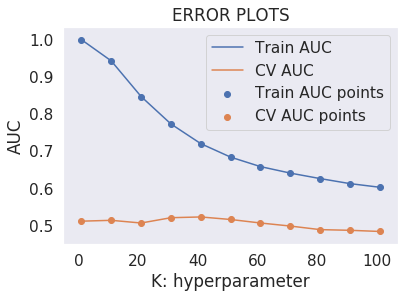

In [86]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


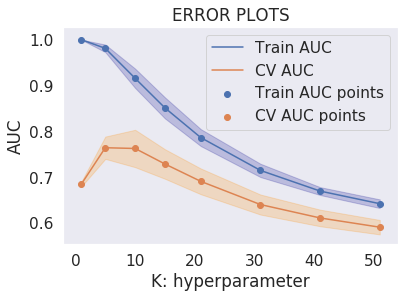

In [87]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_re1, y_re1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


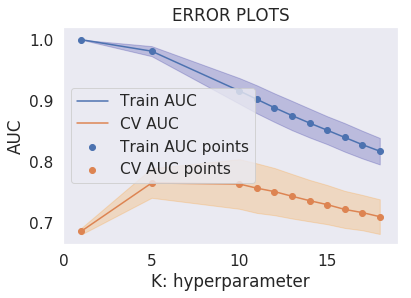

In [88]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 11,12,13, 14,15,16,17,18]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_re1, y_re1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


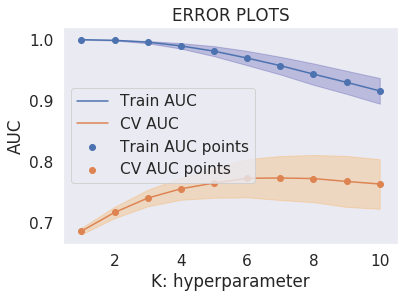

In [89]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_re1, y_re1)
,
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [90]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 6


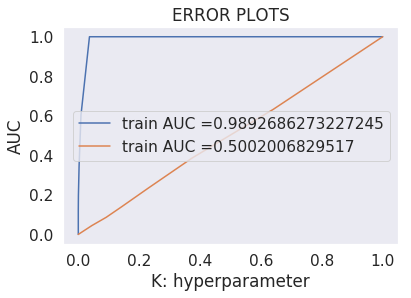

In [91]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_re1, y_re1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_re1)    
y_test_pred = batch_predict(neigh, X_te1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_re1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [92]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [93]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_re1, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.035355016880022336 for threshold 0.167
[[7349  280]
 [   0 7629]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2342169332264854 for threshold 0.333
[[ 620  371]
 [3439 2170]]


the maximum value of tpr*(1-fpr) 0.035355016880022336 for threshold 0.167


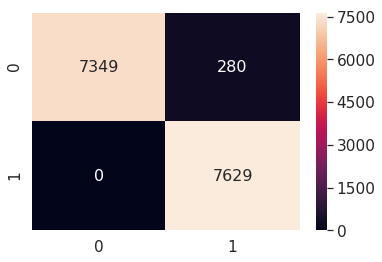

In [94]:
import seaborn as sns
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

# KNN Using W2Vec

In [95]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr2 = hstack((X_train_avg_w2v_vectors,X_train_avg_w2v_vectors_title, X_train_state_ohe,X_train_clean_ohe,X_train_clean_sub_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_prev_projects_norm,X_train_title_count_norm)).tocsr()
X_cr2 = hstack((X_cv_avg_w2v_vectors,X_cv_avg_w2v_vectors_title, X_cv_state_ohe,X_cv_clean_ohe,X_cv_clean_sub_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_prev_projects_norm,X_cv_title_count_norm)).tocsr()
X_te2 = hstack((X_test_avg_w2v_vectors,X_test_avg_w2v_vectors_title, X_test_state_ohe, X_test_clean_ohe,X_test_clean_sub_ohe,X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_prev_projects_norm,X_test_title_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr2.shape, y_train.shape)
print(X_cr2.shape, y_cv.shape)
print(X_te2.shape, y_test.shape)
print("="*100)

Final Data matrix
(8978, 704) (8978,)
(4422, 704) (4422,)
(6600, 704) (6600,)


In [96]:
from imblearn.over_sampling import SMOTE
X_re2, y_re2 = SMOTE().fit_resample(X_tr2, y_train)
print(sorted(Counter(y_re).items()))

[(0, 7629), (1, 7629)]


In [97]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 11, 21, 31, 41, 51, 61, 71,81,91,101]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_re2, y_re2)

    y_train_pred = batch_predict(neigh, X_re2)    
    y_cv_pred = batch_predict(neigh, X_cr2)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_re2,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

100%|██████████| 11/11 [58:27<00:00, 319.44s/it]


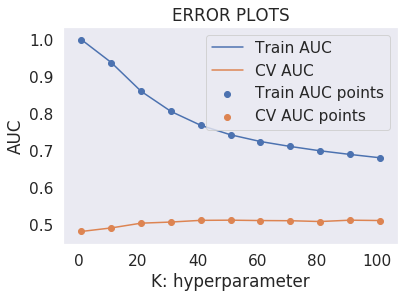

In [98]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


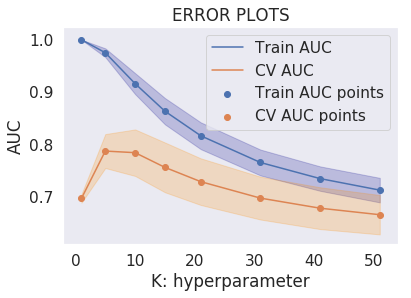

In [99]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_re2, y_re2)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [101]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 6


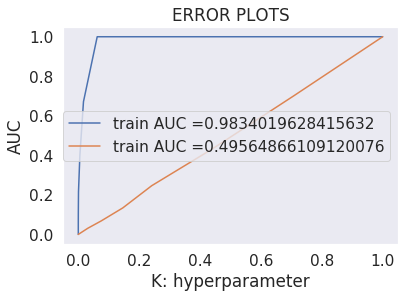

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_re2, y_re2)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_re2)    
y_test_pred = batch_predict(neigh, X_te2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_re2, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [103]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [104]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_re1, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.05827103740940913 for threshold 0.167
[[7155  474]
 [   0 7629]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24627296526457593 for threshold 0.333
[[ 556  435]
 [3190 2419]]


the maximum value of tpr*(1-fpr) 0.05827103740940913 for threshold 0.167


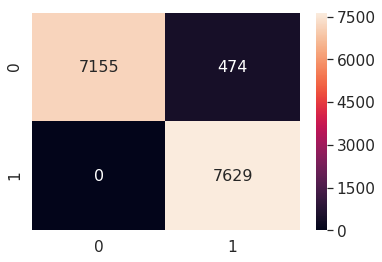

In [105]:
import seaborn as sns
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

# KNN On TFIDF WEIGHTED W2V

In [106]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr3 = hstack((train_tfidf_w2v_vectors_essay,train_tfidf_w2v_vectors_title, X_train_state_ohe,X_train_clean_ohe,X_train_clean_sub_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,X_train_prev_projects_norm,X_train_title_count_norm)).tocsr()
X_cr3 = hstack((cv_tfidf_w2v_vectors_essay,cv_tfidf_w2v_vectors_title, X_cv_state_ohe,X_cv_clean_ohe,X_cv_clean_sub_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,X_cv_prev_projects_norm,X_cv_title_count_norm)).tocsr()
X_te3 = hstack((test_tfidf_w2v_vectors_essay,test_tfidf_w2v_vectors_title, X_test_state_ohe, X_test_clean_ohe,X_test_clean_sub_ohe,X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,X_test_prev_projects_norm,X_test_title_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr3.shape, y_train.shape)
print(X_cr3.shape, y_cv.shape)
print(X_te3.shape, y_test.shape)
print("="*100)

Final Data matrix
(8978, 704) (8978,)
(4422, 704) (4422,)
(6600, 704) (6600,)


In [107]:
from imblearn.over_sampling import SMOTE
X_re3, y_re3 = SMOTE().fit_resample(X_tr3, y_train)
print(sorted(Counter(y_re).items()))

[(0, 7629), (1, 7629)]


In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []

K = [1, 11, 21, 31, 41, 51, 61, 71,81,91,101]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_re3, y_re3)

    y_train_pred = batch_predict(neigh, X_re3)    
    y_cv_pred = batch_predict(neigh, X_cr3)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_re3,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

100%|██████████| 11/11 [58:29<00:00, 320.11s/it]


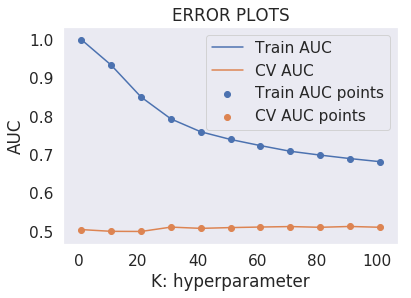

In [109]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


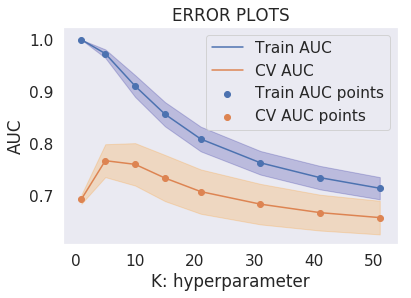

In [110]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_re3, y_re3)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [111]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 6


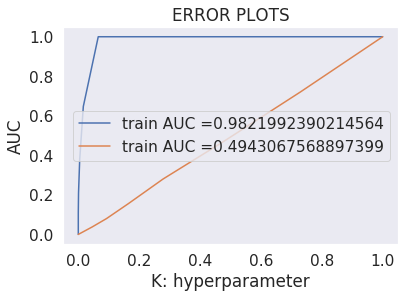

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_re3, y_re3)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_re3)    
y_test_pred = batch_predict(neigh, X_te3)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_re1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [113]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [114]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_re3, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.061243977639737 for threshold 0.167
[[7129  500]
 [   0 7629]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24938879786901488 for threshold 0.333
[[ 520  471]
 [2984 2625]]


the maximum value of tpr*(1-fpr) 0.061243977639737 for threshold 0.167


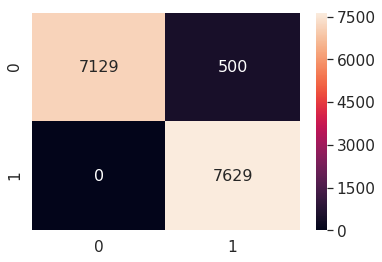

In [115]:
import seaborn as sns
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

In [116]:
#kbest feature selection

from sklearn.feature_selection import SelectKBest, chi2, f_regression
X_tr_new=SelectKBest(score_func=chi2,k=2000).fit_transform(X_re1,y_re1)
X_te_new = SelectKBest(chi2, k=2000).fit_transform(X_te1, y_test)
X_cr_new = SelectKBest(chi2, k=2000).fit_transform(X_cr1, y_cv)
print(X_tr_new.shape)
print(X_te_new.shape)
print(X_cr_new.shape)



(15258, 2000)
(6600, 2000)
(4422, 2000)


In [117]:
train_auc = []
cv_auc = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr_new, y_re1)

    y_train_pred = batch_predict(neigh, X_tr_new)    
    y_cv_pred = batch_predict(neigh, X_cr_new)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_re1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|██████████| 12/12 [02:42<00:00, 13.87s/it]


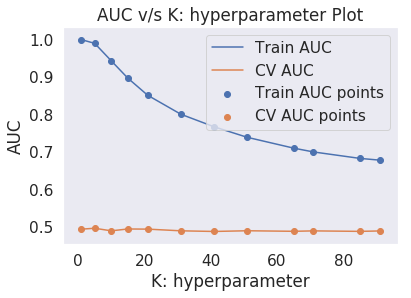

In [118]:

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC v/s K: hyperparameter Plot")
plt.grid()
plt.show()

/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ANT.AMAZON.COM/sagchakr/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


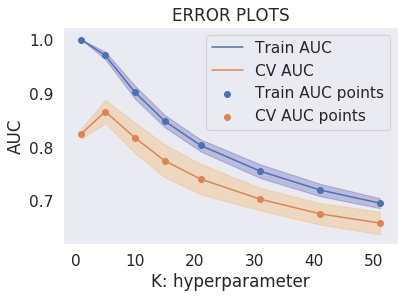

In [119]:
#Hyperparameter tunning using grid search or random search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr_new, y_re1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [121]:
#optimum K
best_k_5 = 6

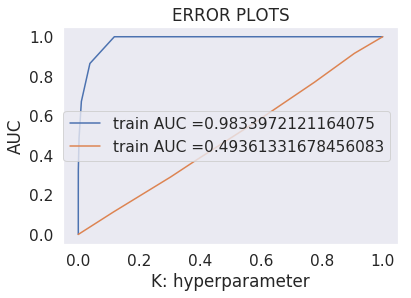

In [124]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_tr_new, y_re1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr_new)    
y_test_pred = batch_predict(neigh, X_te_new)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_re1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [126]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [127]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_re3, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.10435406795488808 for threshold 0.167
[[6726  903]
 [   0 7629]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2429005346809479 for threshold 0.5
[[ 412  579]
 [2411 3198]]


the maximum value of tpr*(1-fpr) 0.10435406795488808 for threshold 0.167


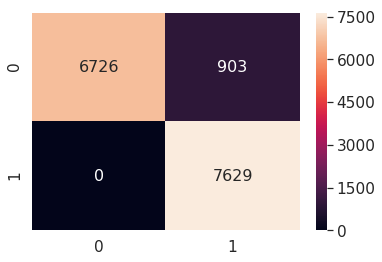

In [128]:
import seaborn as sns
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_re, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

In [129]:
#Summarized

# Compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["BOW", "Brute", 91, 0.63])
x.add_row(["TFIDF", "Brute", 85, 0.57])
x.add_row(["AVG W2V", "Brute", 91, 0.6])
x.add_row(["TFIDF W2V", "Brute", 85, 0.55])
x.add_row(["TFIDF", "Top 2000", 85, 0.51])

print(x)



+------------+----------+-----------------+------+
| Vectorizer |  Model   | Hyper Parameter | AUC  |
+------------+----------+-----------------+------+
|    BOW     |  Brute   |        91       | 0.63 |
|   TFIDF    |  Brute   |        85       | 0.57 |
|  AVG W2V   |  Brute   |        91       | 0.6  |
| TFIDF W2V  |  Brute   |        85       | 0.55 |
|   TFIDF    | Top 2000 |        85       | 0.51 |
+------------+----------+-----------------+------+
